<center><b><font size=6>Supervised learning – classification<b><center>

This notebook implements the supervised learning component of the SSH Shell Attack session project. The primary goal is to classify attack session tactics based on patterns identified in the dataset.

Steps:

0. **Install Dependencies**
1. **Data Splitting**
2. **Baseline Model Implementation**
3. **Hyperparameter Tuning**
4. **Comparing models**

<center><b><font size=5>Install Dependencies<b><center>

In this step, we install the necessary dependencies and import the required libraries for data processing, model training, evaluation, and visualization.

In [1]:
!python ../scripts/install_dependencies.py section2

Installing common packages: pandas, pyarrow
Installing Section 2 packages: matplotlib, seaborn, scikit-learn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../')

from scripts.data_processing import sampling, split_train_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, make_scorer
)
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from scripts.data_storage_utils import save_plot

In [3]:
# Global variables
global_overwrite = True
plot_directory = "../results/figures/plots/section2"

<center><b><font size=5>Data Splitting<b><center>

Split the dataset into training and testing sets.

**Steps:**

- Data Loading
- Data Splitting
- Multi-Label Transformation
- Summary

### Data Loading

- Loads the dataset from a Parquet file into a Pandas DataFrame.

In [4]:
# Load Dataset
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
#SSH_Attacks

### Data Splitting

- Define Features (X) and Labels (y)
- Split Data into Training and Testing Sets
- Preprocess Text Data
- Vectorize Text with TF-IDF


In [5]:
# Dataset 100%
X = SSH_Attacks['full_session']  # Text data
y = SSH_Attacks['Set_Fingerprint']  # Multi-label target

# # Campiona il 10% del dataset
# SSH_Attacks_sampled = sampling(SSH_Attacks, 2, 0.10)

# # Separazione delle caratteristiche (X) e del target (y)
# X = SSH_Attacks_sampled['full_session']  # Text data
# y = SSH_Attacks_sampled['Set_Fingerprint']  # Multi-label target

# Ensure a 70/30 split while maintaining reproducibility (random_state=42).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Convert to strings to ensure compatibility with TfidfVectorizer
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Vectorize the text data using TF-IDF (standardization is included in TF-IDF by default)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Controllo delle dimensioni dei dati vettorizzati
print(f"Train set TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test set TF-IDF shape: {X_test_tfidf.shape}")

Train set TF-IDF shape: (163124, 66)
Test set TF-IDF shape: (69911, 66)


### Multi-Label Transformation

- Transform Labels to Binary Format


In [6]:
# Fit the MultiLabelBinarizer on the training set labels only
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Transform the training and test labels into binary matrices
y_train_binary = pd.DataFrame(mlb.transform(y_train), columns=mlb.classes_, index=y_train.index)
y_test_binary = pd.DataFrame(mlb.transform(y_test), columns=mlb.classes_, index=y_test.index)

### Summary

- Ensures the processed data is correctly prepared for modeling.


In [7]:
# Print basic info about the processed data
print("Processed Training set size:", len(X_train))
print("Processed Testing set size:", len(X_test))
print("\nShape of y_train_binary:", y_train_binary.shape)
print("Shape of y_test_binary:", y_test_binary.shape)
print("\nClasses:", mlb.classes_)

# Check sparsity of TF-IDF matrices
if hasattr(X_train_tfidf, 'nnz') and hasattr(X_test_tfidf, 'nnz'):
    train_sparsity = (X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)) * 100
    test_sparsity = (X_test_tfidf.nnz / np.prod(X_test_tfidf.shape)) * 100
    print("\nTrain Sparsity: {:.2f}%".format(train_sparsity))
    print("Test Sparsity: {:.2f}%".format(test_sparsity))
else:
    print("\nSparsity information not available for the given data format.")


Processed Training set size: 163124

Processed Testing set size: 69911

Shape of y_train_binary: (163124, 7)

Shape of y_test_binary: (69911, 7)

Classes: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


<center><b><font size=5>Baseline Model Implementation<b><center>

**Steps:**

- Choose different ML models.
- Logistic Regression - Training and Evaluation.
- Random Forest - Training and Evaluation.
- Support Vector Machine (SVM) - Training and Evaluation.
- Compare performance and check for overfitting/underfitting.

### Choose and initialize models

In this step, we select and initialize the models to use for multilabel classification. We use the OneVsRestClassifier to handle multilabel tasks, which allows us to train one classifier per label.

The models selected for this evaluation are:

- Logistic Regression with max_iter=1000 for convergence.
- Random Forest with 100 estimators and a fixed random seed to ensure reproducibility.
- Support Vector Machine (SVM) with a linear kernel for simplicity and effectiveness in high-dimensional spaces.

These models are initialized and stored in a dictionary for easy access.

In [8]:
# Initialize models with OneVsRestClassifier for multilabel classification
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "SVM": OneVsRestClassifier(SVC(kernel='linear', random_state=42))
}

# Store results for comparison
model_results = {}
performance_summaries = []

In [10]:
def train_and_evaluate(model, model_name, X_train, X_test, y_train_binary, y_test_binary):
    """
    Train a given model for each label and evaluate its performance.
    Adds overfitting check based on accuracy difference between train and test sets.
    """
    results = {}
    performance_summary = []
    
    # Prepare figure for heatmaps
    num_labels = len(y_train_binary.columns)
    num_cols = 4
    num_rows = (num_labels + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, num_rows * 6))
    axes = axes.flatten()

    # Train and evaluate the model for each label
    for i, label in enumerate(y_train_binary.columns):
        start_time = time.time()
        
        # Train the model and make predictions
        model.fit(X_train, y_train_binary[label])
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        execution_time = time.time() - start_time
        results[label] = {
            "train_predictions": y_train_pred,
            "test_predictions": y_test_pred,
            "execution_time": execution_time
        }

        # Classification reports
        report_train = classification_report(y_train_binary[label], y_train_pred, zero_division=0, output_dict=True)
        report_test = classification_report(y_test_binary[label], y_test_pred, zero_division=0, output_dict=True)
        results[label]["classification_report_train"] = report_train
        results[label]["classification_report_test"] = report_test
        
        # Confusion matrix for heatmap
        cm = confusion_matrix(y_test_binary[label], y_test_pred)
        results[label]["confusion_matrix"] = cm

        # Plot confusion matrix as heatmap
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True,
                    xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"],
                    annot_kws={"size": 14, "weight": 'bold'}, linewidths=2, linecolor='gray', ax=ax)
        ax.set_title(f"{model_name}\nConfusion Matrix for {label}\n", fontsize=15, weight='bold', linespacing=1.5)
        ax.set_ylabel('True Label', fontsize=15)
        ax.set_xlabel('Predicted Label', fontsize=15)
        ax.tick_params(axis='both', labelsize=12)
    
    # Remove excess axes
    for j in range(num_labels, len(axes)):
        fig.delaxes(axes[j])

    # Summary and overfitting check
    for label, metrics in results.items():
        for set_name, report_dict in [("Train", metrics["classification_report_train"]), ("Test", metrics["classification_report_test"])]:
            # Prepare performance summary
            performance_summary.append({
                "Model": model_name,
                "Set": set_name,
                "Attack": label,
                "Precision": report_dict["macro avg"]["precision"],
                "Recall": report_dict["macro avg"]["recall"],
                "F1-Score": report_dict["macro avg"]["f1-score"],
                "Accuracy": report_dict["accuracy"],
                "Execution Time (s)": metrics["execution_time"] if set_name == "Test" else None
            })
        
        # Check for overfitting (accuracy difference)
        accuracy_diff = abs(results[label]["classification_report_train"]["accuracy"] - results[label]["classification_report_test"]["accuracy"])
        if accuracy_diff > 0.1:  # Arbitrary threshold for overfitting
            print(f"\n[Overfitting Detected] {model_name} - Label: {label}")
            print(f"Train Accuracy: {results[label]['classification_report_train']['accuracy']:.4f}, Test Accuracy: {results[label]['classification_report_test']['accuracy']:.4f}")
            print(f"Accuracy Difference: {accuracy_diff:.4f}")
        else:
            print(f"[No Overfitting] {model_name} - Label: {label}\n")
    
    # Save and show plots
    current_fig = plt.gcf()
    save_plot(current_fig, plot_directory, f"{model_name}_normalized_confusion_matrix_test", "png", global_overwrite)
    
    plt.tight_layout(h_pad=4.0)  
    plt.show()

    # Create summary dataframes
    performance_summary_df = pd.DataFrame(performance_summary)
    train_summary_df = performance_summary_df[performance_summary_df["Set"] == "Train"]
    test_summary_df = performance_summary_df[performance_summary_df["Set"] == "Test"]
    
    return results, train_summary_df, test_summary_df

### Logistic Regression

In this section, we train the Logistic Regression model on the training set and evaluate its performance on both the training and test sets. The evaluation includes:

- Confusion matrix for visualizing prediction errors.
- Classification report detailing precision, recall, F1-score, and accuracy.
- The performance on the train and test sets is printed and added to the summary for comparison.

[No Overfitting] Logistic Regression - Label: Defense Evasion

[No Overfitting] Logistic Regression - Label: Discovery

[No Overfitting] Logistic Regression - Label: Execution

[No Overfitting] Logistic Regression - Label: Harmless

[No Overfitting] Logistic Regression - Label: Impact

[No Overfitting] Logistic Regression - Label: Other

[No Overfitting] Logistic Regression - Label: Persistence

Plot saved successfully at: '../results/figures/plots/section2/Logistic Regression_normalized_confusion_matrix_test.png'


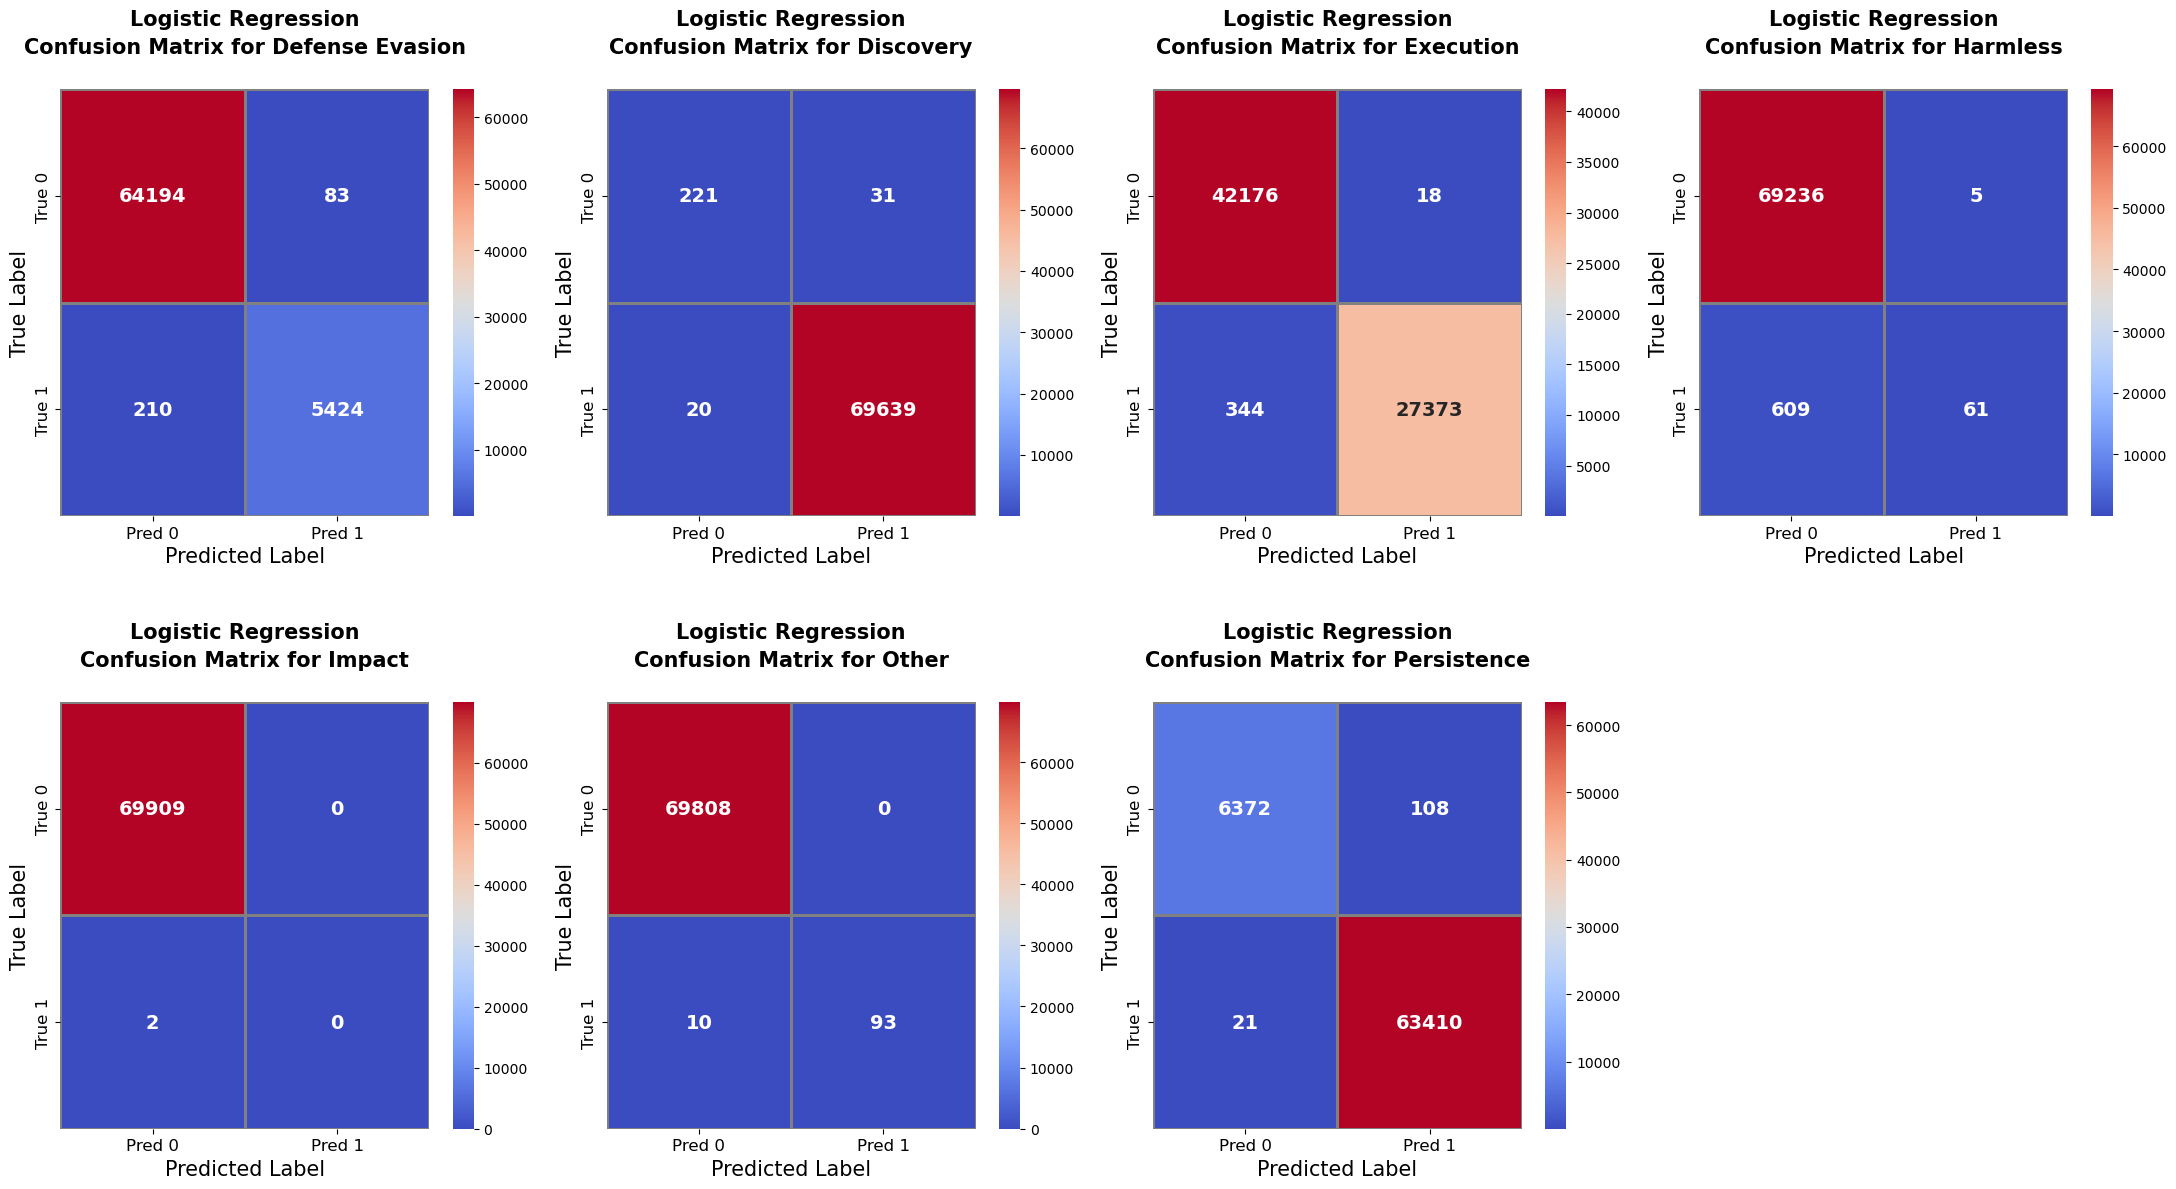


PERFORMANCE ON TRAIN SET: Logistic Regression

              Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression Train Defense Evasion   0.991190 0.983378  0.987246  0.996193                 NaN
Logistic Regression Train       Discovery   0.949198 0.938678  0.943875  0.999136                 NaN
Logistic Regression Train       Execution   0.996003 0.994221  0.995092  0.995298                 NaN
Logistic Regression Train        Harmless   0.978597 0.545883  0.581672  0.991418                 NaN
Logistic Regression Train          Impact   0.499923 0.500000  0.499962  0.999847                 NaN
Logistic Regression Train           Other   0.995137 0.959815  0.976821  0.999877                 NaN
Logistic Regression Train     Persistence   0.997701 0.991725  0.994691  0.998210                 NaN

PERFORMANCE ON TEST SET: Logistic Regression

              Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Executi

In [11]:
# Train and evaluate Logistic Regression
model_name = "Logistic Regression"
model = models[model_name]

# Chiamata alla funzione che restituisce i risultati e i DataFrame per train e test
model_results[model_name], performance_comparison_lr_train, performance_comparison_lr_test = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

# Stampa la tabella dei risultati per il train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_lr_train.to_string(index=False, max_colwidth=20))

# Stampa la tabella dei risultati per il test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_lr_test.to_string(index=False, max_colwidth=20))

# Aggiungi i DataFrame alla lista delle performance
performance_summaries.append(performance_comparison_lr_train)
performance_summaries.append(performance_comparison_lr_test)

### Random Forest

Here, the Random Forest model is trained on the training data, and its performance is evaluated similarly to Logistic Regression. The results, including the confusion matrix and classification report, are computed and displayed.

[No Overfitting] Random Forest - Label: Defense Evasion

[No Overfitting] Random Forest - Label: Discovery

[No Overfitting] Random Forest - Label: Execution

[No Overfitting] Random Forest - Label: Harmless

[No Overfitting] Random Forest - Label: Impact

[No Overfitting] Random Forest - Label: Other

[No Overfitting] Random Forest - Label: Persistence

Plot saved successfully at: '../results/figures/plots/section2/Random Forest_normalized_confusion_matrix_test.png'


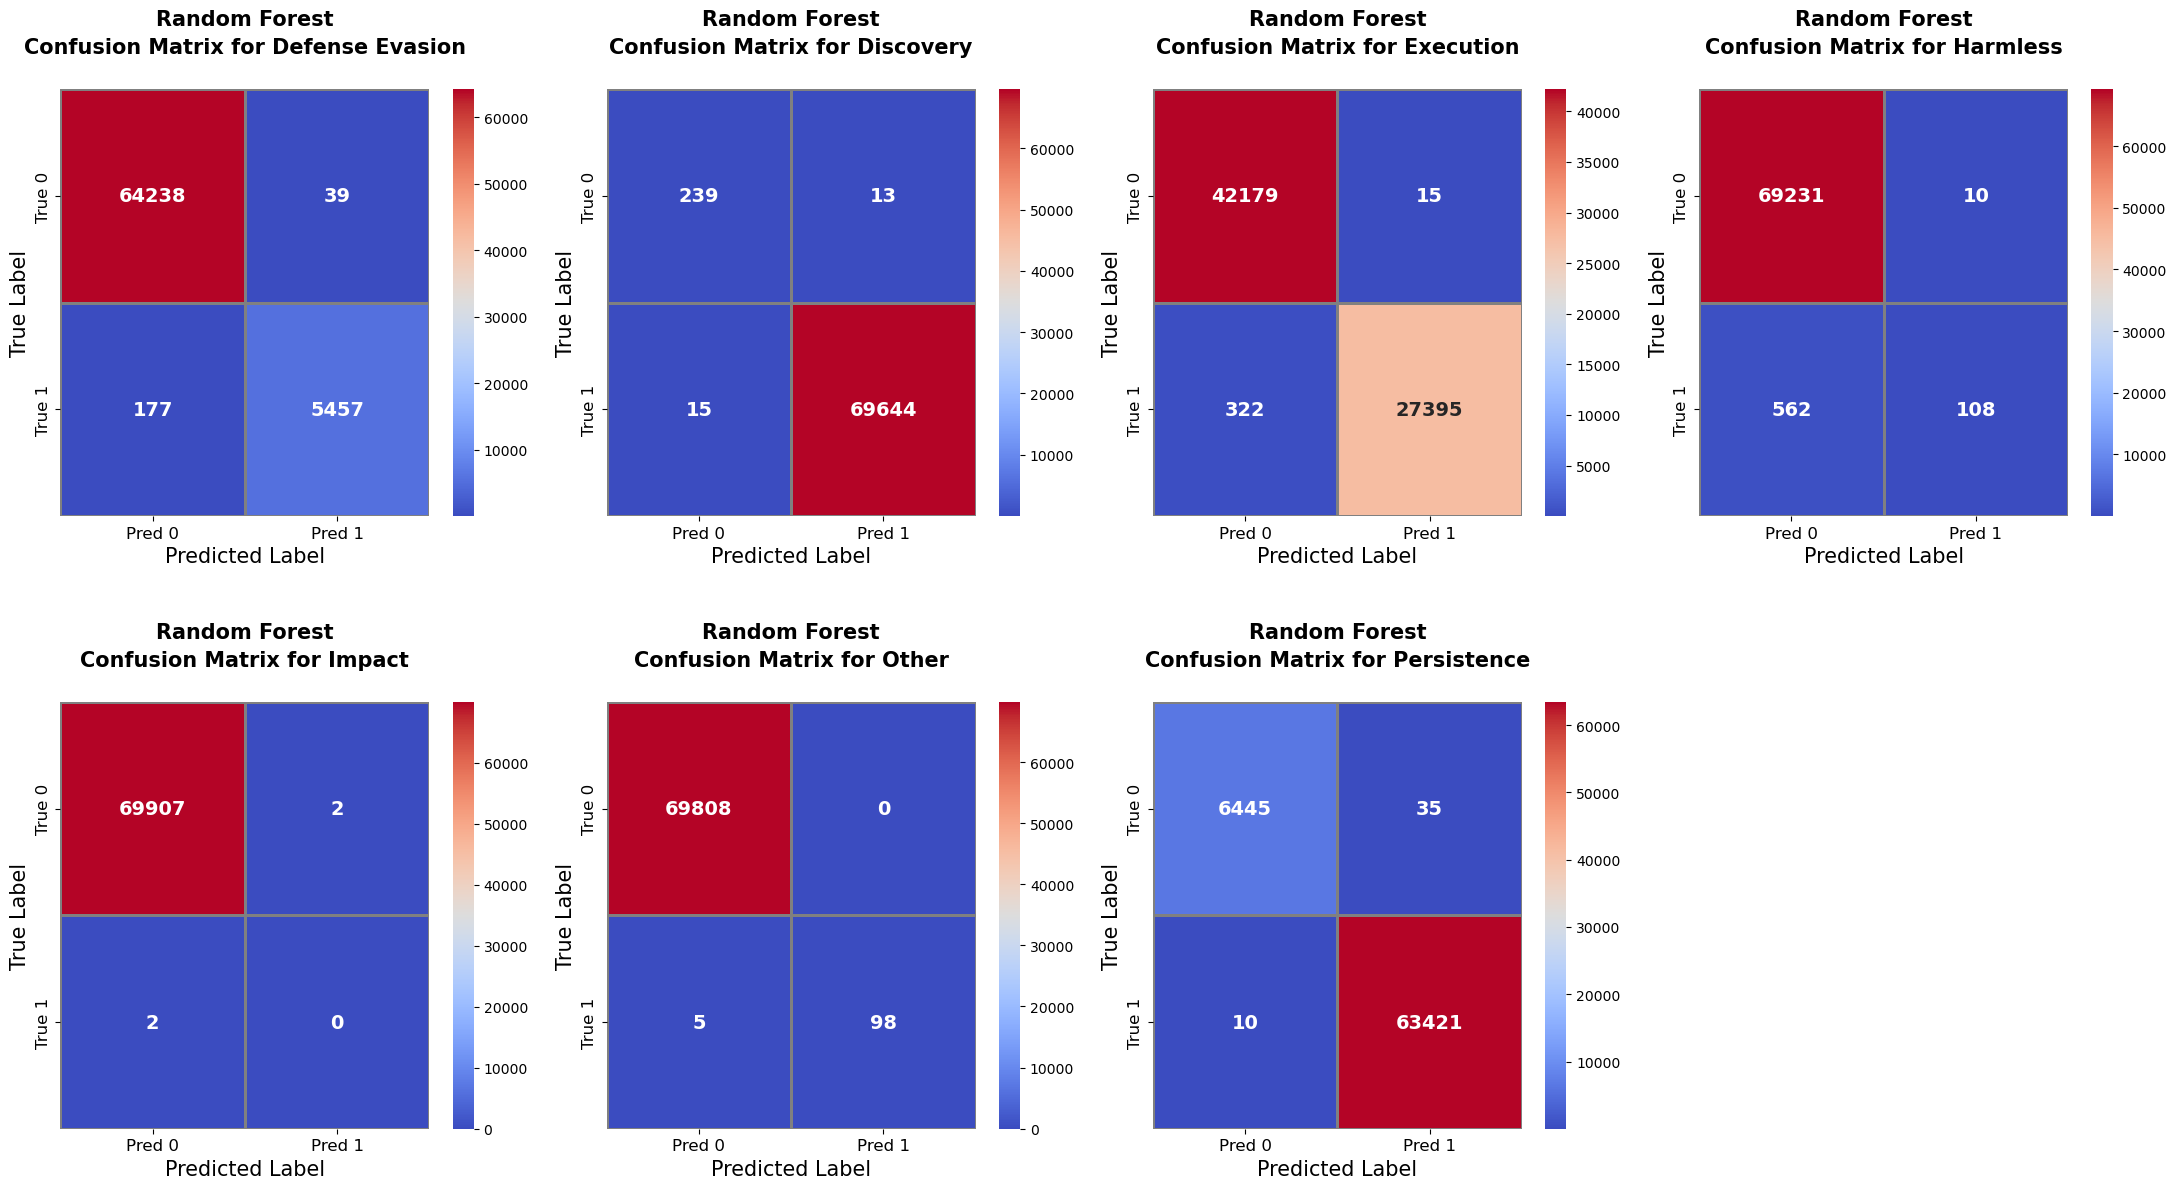


PERFORMANCE ON TRAIN SET: Random Forest

        Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Random Forest Train Defense Evasion   0.996443 0.986883  0.991606  0.997499                 NaN
Random Forest Train       Discovery   0.995269 0.994496  0.994882  0.999920                 NaN
Random Forest Train       Execution   0.996632 0.994922  0.995758  0.995936                 NaN
Random Forest Train        Harmless   0.962743 0.595313  0.656430  0.992251                 NaN
Random Forest Train          Impact   0.999994 0.960000  0.979164  0.999988                 NaN
Random Forest Train           Other   0.999994 0.995536  0.997755  0.999988                 NaN
Random Forest Train     Persistence   0.999491 0.997905  0.998697  0.999559                 NaN

PERFORMANCE ON TEST SET: Random Forest

        Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Random Forest Test Defense Evasion   0.995078 0.983988

In [12]:
# Train and evaluate Random Forest
model_name = "Random Forest"
model = models[model_name]

# Chiamata alla funzione che restituisce i risultati e i DataFrame per train e test
model_results[model_name], performance_comparison_rf_train, performance_comparison_rf_test = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

# Stampa la tabella dei risultati per il train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_rf_train.to_string(index=False, max_colwidth=20))

# Stampa la tabella dei risultati per il test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_rf_test.to_string(index=False, max_colwidth=20))

# Aggiungi i DataFrame alla lista delle performance
performance_summaries.append(performance_comparison_rf_train)
performance_summaries.append(performance_comparison_rf_test)

### Support Vector Machine (SVM)

The SVM model is trained and evaluated in the same manner as the previous models. The confusion matrix and classification report are generated, and the results are stored for comparison.

[No Overfitting] SVM - Label: Defense Evasion

[No Overfitting] SVM - Label: Discovery

[No Overfitting] SVM - Label: Execution

[No Overfitting] SVM - Label: Harmless

[No Overfitting] SVM - Label: Impact

[No Overfitting] SVM - Label: Other

[No Overfitting] SVM - Label: Persistence

Plot saved successfully at: '../results/figures/plots/section2/SVM_normalized_confusion_matrix_test.png'


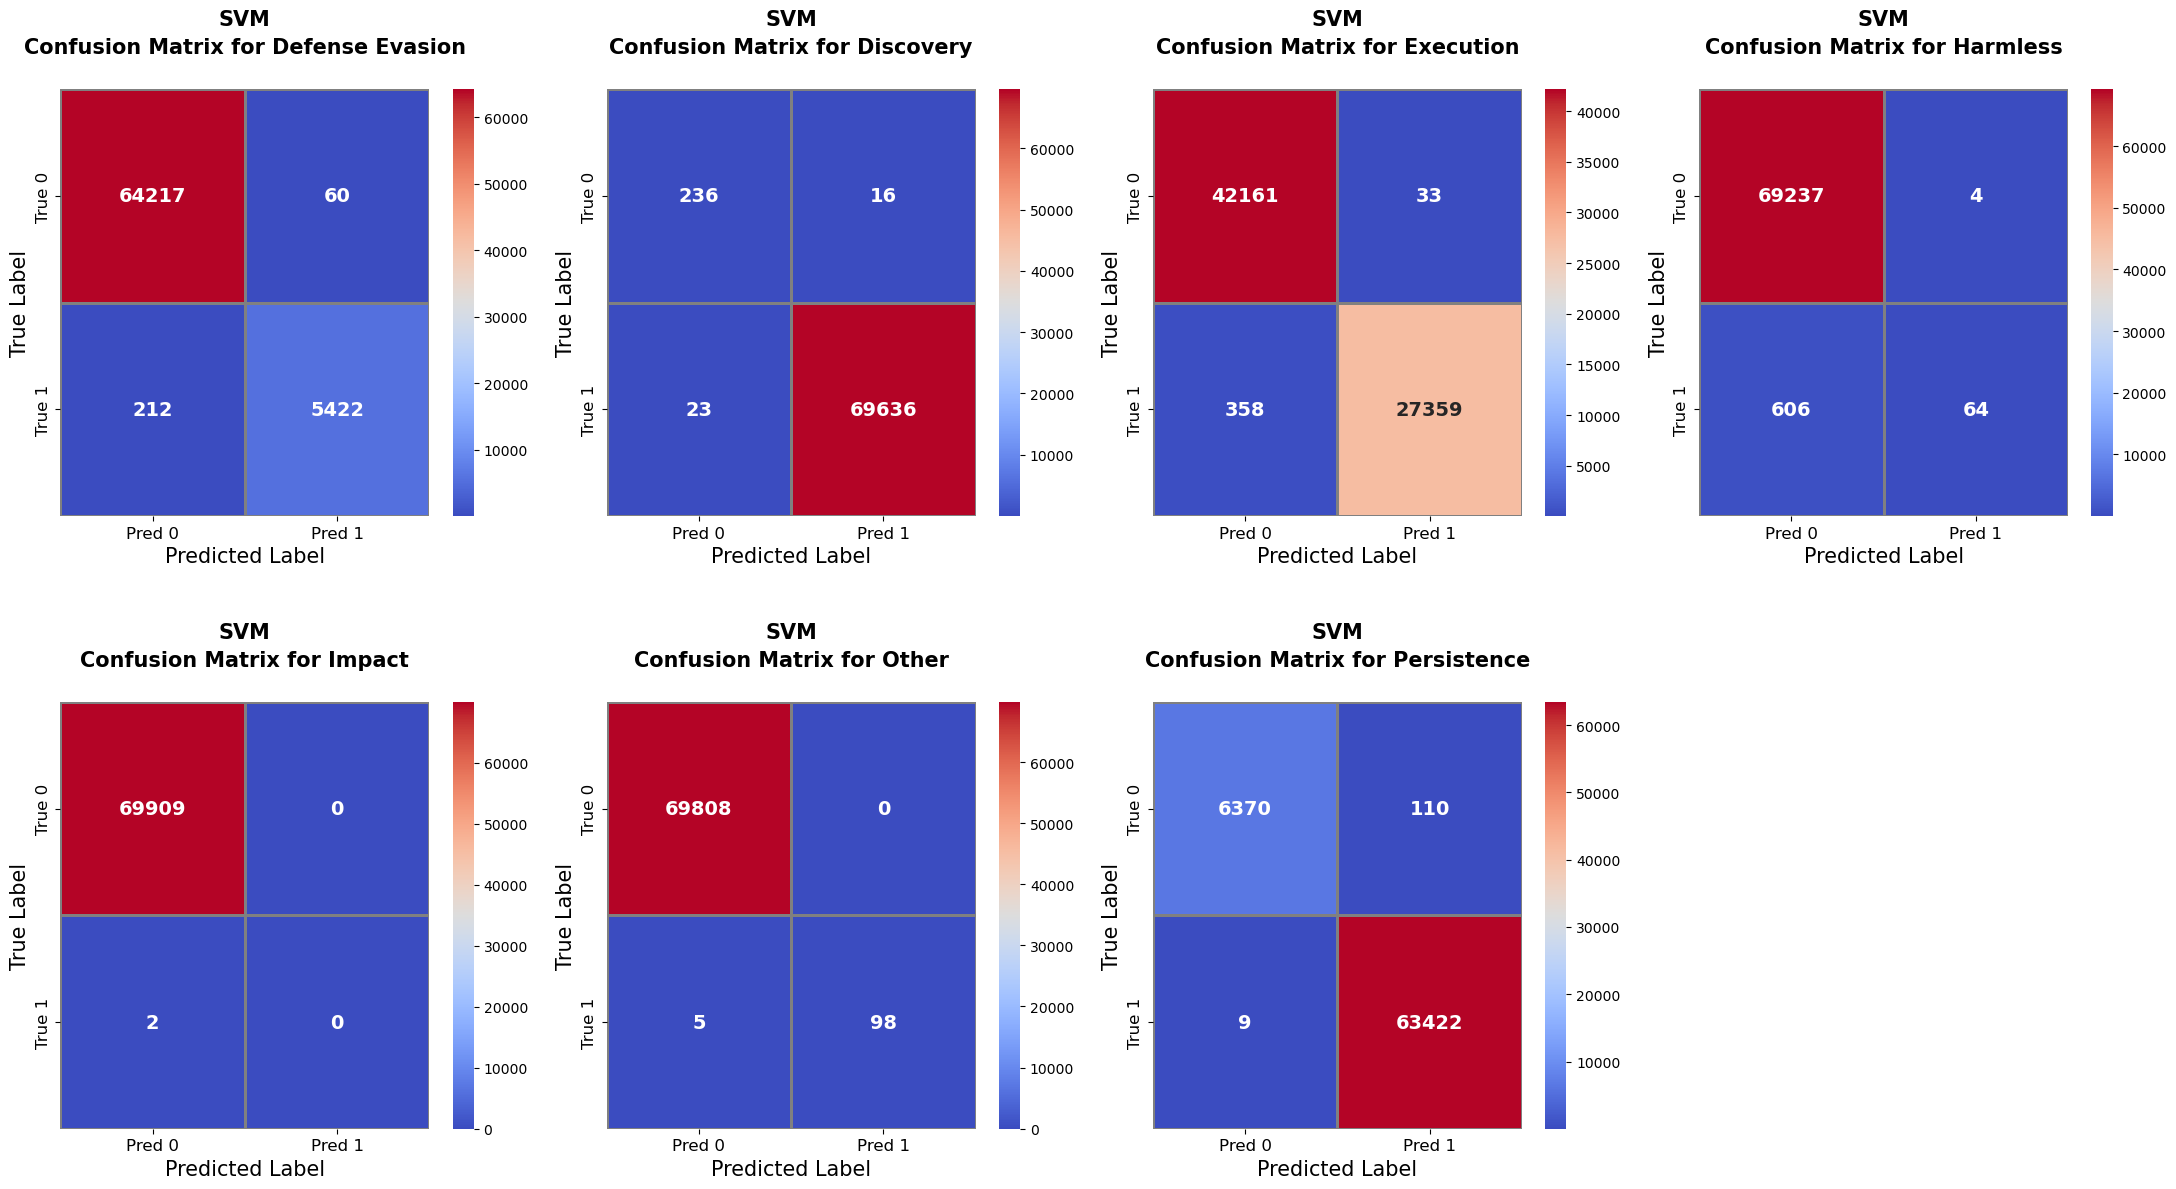


PERFORMANCE ON TRAIN SET: SVM

Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
  SVM Train Defense Evasion   0.993119 0.983252  0.988125  0.996463                 NaN
  SVM Train       Discovery   0.948790 0.974709  0.961383  0.999381                 NaN
  SVM Train       Execution   0.995573 0.993769  0.994651  0.994875                 NaN
  SVM Train        Harmless   0.978951 0.546860  0.583308  0.991436                 NaN
  SVM Train          Impact   0.499923 0.500000  0.499962  0.999847                 NaN
  SVM Train           Other   0.999963 0.973214  0.986220  0.999926                 NaN
  SVM Train     Persistence   0.998469 0.992160  0.995289  0.998412                 NaN

PERFORMANCE ON TEST SET: SVM

Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
  SVM Test Defense Evasion   0.992882 0.980719  0.986709  0.996109          559.841188
  SVM Test       Discovery   0.955484 0.968089  0.961700  0

In [13]:
# Train and evaluate SVM 
model_name = "SVM"
model = models[model_name]

# Chiamata alla funzione che restituisce i risultati e i DataFrame per train e test
model_results[model_name], performance_comparison_svm_train, performance_comparison_svm_test = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

# Stampa la tabella dei risultati per il train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_svm_train.to_string(index=False, max_colwidth=20))

# Stampa la tabella dei risultati per il test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_svm_test.to_string(index=False, max_colwidth=20))

# Aggiungi i DataFrame alla lista delle performance
performance_summaries.append(performance_comparison_svm_train)
performance_summaries.append(performance_comparison_svm_test)

### Compare performances

In this step, we compare the performance of all models by calculating the average metrics for both the training and test sets.
We also check for signs of overfitting or underfitting by examining the difference between training and test accuracy.

Overfitting can be detected if the model performs significantly better on the training set compared to the test set (e.g., accuracy difference greater than a threshold like 0.1).
Underfitting can be seen if the model performs poorly on both training and test sets.

The model with the best overall performance will be identified based on the metrics and consistency between training and test results.

In [14]:
def compare_train_test(performance_summaries):
    """
    Compare models by calculating and displaying mean metrics for train and test sets separately.
    Adds average execution time per model.
    """
    train_summaries = []
    test_summaries = []

    # Itera su ciascun modello per raccogliere i risultati
    for idx, summary in enumerate(performance_summaries):
        model_name = summary["Model"].iloc[0]  # Assumiamo che ogni summary abbia la stessa 'Model' per ogni label

        if idx % 2 == 0: 
            # Filtra i risultati per il train set e calcola la media delle colonne numeriche
            train_metrics = summary[summary["Set"] == "Train"].select_dtypes(include='number').mean().to_dict()
            train_metrics["Model"] = model_name
            train_summaries.append(train_metrics)
        else: 
            # Filtra i risultati per il test set e calcola la media delle colonne numeriche
            test_metrics = summary[summary["Set"] == "Test"].select_dtypes(include='number').mean().to_dict()
            test_metrics["Model"] = model_name
            test_summaries.append(test_metrics)


    # Crea DataFrame per le tabelle train e test
    train_df = pd.DataFrame(train_summaries)
    test_df = pd.DataFrame(test_summaries)

    # Calcola la media del tempo di esecuzione (solo sul test set)
    avg_test_time = test_df["Execution Time (s)"].mean()

    # Aggiungi la media del tempo alla stampa
    print(f"Average Test Time: {avg_test_time:.4f} seconds")

    # Ordina le colonne mettendo "Model" per prima
    cols_train = ["Model"] + [col for col in train_df.columns if col != "Model"]
    train_df = train_df[cols_train]

    cols_test = ["Model"] + [col for col in test_df.columns if col != "Model"]
    test_df = test_df[cols_test]

    # Stampa i risultati
    print(f"\n{'='*69}\nTRAIN SET COMPARISON \n{'='*69}\n")
    print(train_df.to_string(index=False, max_colwidth=20))  # Tabella per il train set

    print(f"\n{'='*69}\nTEST SET COMPARISON \n{'='*69}\n")
    print(test_df.to_string(index=False, max_colwidth=20))  # Tabella per il test set

In [15]:
# Compare models
compare_train_test(performance_summaries)

Average Test Time: 64.1123 seconds

TRAIN SET COMPARISON 

              Model  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression   0.915393 0.844814  0.854194  0.997140                 NaN
      Random Forest   0.992938 0.932151  0.944899  0.997877                 NaN
                SVM   0.916398 0.851995  0.858420  0.997191                 NaN

TEST SET COMPARISON 

              Model  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression   0.914275 0.843013  0.853998  0.997015            1.477348
      Random Forest   0.916271 0.857937  0.868179  0.997534           22.990261
                SVM   0.915455 0.850980  0.858503  0.997062          167.869378


<center><b><font size=5>Hyperparameter Tuning<b><center>

Fine-tune the hyperparameters of the ML models using cross-validation.

"Tune the hyper-parameters of the models through cross-validation. How do performance vary?"

**Steps:**

TO BE CHECKED

- Use GridSearchCV to tune hyperparameters.
- Evaluate the performance of the tuned models.
- Compare the results with baseline performance.

### text

- text
- text

In [16]:
param_grid_logreg = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__solver': ['liblinear', 'saga', 'lbfgs'],
    'estimator__max_iter': [2000]
}

param_grid_rf = {
    'estimator__n_estimators': [10, 50, 100],
    'estimator__max_depth': [10, 50, 100, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__random_state': [42]
}

param_grid_svm = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto'],
    'estimator__random_state': [42]
}

In [17]:
# Funzione per eseguire il GridSearch
def hyperparameter_tuning_with_gridsearch(model_name, model, param_grid, X_train, y_train_binary):
    """
    Esegui il GridSearchCV per ottimizzare gli iperparametri del modello.
    Utilizza OneVsRestClassifier per la classificazione multilabel.
    """
    ovr_model = OneVsRestClassifier(model)
    scorer = make_scorer(f1_score, average='weighted', zero_division=1)
    
    grid_search = GridSearchCV(estimator=ovr_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring=scorer)  
    
    print(f"\nTuning hyperparameters for {model_name}...\n")
    
    start_time = time.time()
    grid_search.fit(X_train, y_train_binary)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print(f"\nTime to train the model: {elapsed_time:.2f} seconds")
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    print(f"\nBest cross-validation score for {model_name}: {grid_search.best_score_:.4f}\n")
    
    return grid_search


Tuning hyperparameters for Logistic Regression...

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Time to train the model: 839.61 seconds

Best parameters for Logistic Regression: {'estimator__C': 100, 'estimator__max_iter': 2000, 'estimator__solver': 'lbfgs'}

Best cross-validation score for Logistic Regression: 0.9951

Overwriting file: '../results/figures/plots/section2/weighted_f1_score_for_each_combination_of_parameters_logistic_regression.png'
Plot saved successfully at: '../results/figures/plots/section2/weighted_f1_score_for_each_combination_of_parameters_logistic_regression.png'


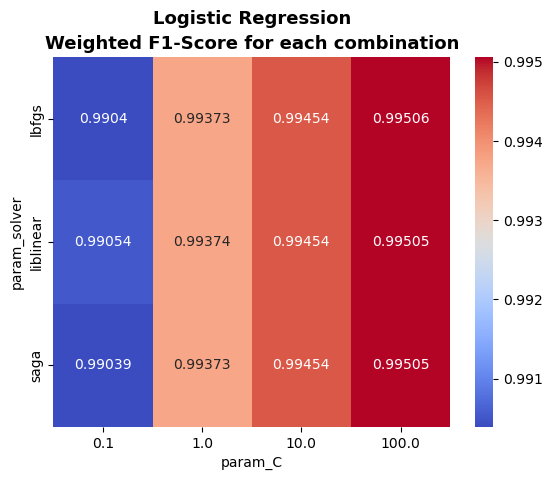

In [18]:
# Esegui GridSearch per Logistic Regression con OneVsRestClassifier
best_logreg_model = hyperparameter_tuning_with_gridsearch(
    "Logistic Regression", LogisticRegression(max_iter=2000, random_state=42), param_grid_logreg, X_train_tfidf, y_train_binary
)

results_logreg = pd.DataFrame(best_logreg_model.cv_results_)

# Crea una pivot table
scores_logreg = results_logreg.pivot(index='param_estimator__solver', 
                                     columns='param_estimator__C', 
                                     values='mean_test_score')

# Visualizza la heatmap
sns.heatmap(scores_logreg, annot=True, cmap='coolwarm', fmt='.5g')
plt.xlabel('param_C')
plt.ylabel('param_solver')
plt.title('Logistic Regression\nWeighted F1-Score for each combination', fontsize=13, weight='bold', linespacing=1.5)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "weighted_f1_score_for_each_combination_of_parameters_logistic_regression", "png", global_overwrite)

# Show the plot
plt.show()

In [ ]:
# Esegui GridSearch per Random Forest con OneVsRestClassifier
best_rf_model = hyperparameter_tuning_with_gridsearch(
    "Random Forest", RandomForestClassifier(random_state=42), param_grid_rf, X_train_tfidf, y_train_binary
)

results_rf = pd.DataFrame(best_rf_model.cv_results_)  # cv_results_ contiene i dettagli della GridSearch

# Rimuovi eventuali duplicati
results_rf = results_rf.drop_duplicates(subset=['param_estimator__max_depth', 'param_estimator__n_estimators'])

# Crea la pivot table senza duplicati
scores_rf = results_rf.pivot(index='param_estimator__max_depth', 
                             columns='param_estimator__n_estimators', 
                             values='mean_test_score')

# Heatmap
sns.heatmap(scores_rf, annot=True, cmap='coolwarm', fmt='.5g')
plt.xlabel('param_n_estimators')
plt.ylabel('param_max_depth')
plt.title('Random Forest\nWeighted F1-Score for each combination', fontsize=13, weight='bold', linespacing=1.5)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "weighted_f1_score_for_each_combination_of_parameters_random_forest", "png", global_overwrite)

# Show the plot
plt.show()


Tuning hyperparameters for Random Forest...

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
# Esegui GridSearch per SVM con OneVsRestClassifier
best_svm_model = hyperparameter_tuning_with_gridsearch(
    "SVM", SVC(random_state=42), param_grid_svm, X_train_tfidf, y_train_binary
)

results_svm = pd.DataFrame(best_svm_model.cv_results_)

# Creare la pivot table con param_kernel e param_C come indice e colonne
scores_svm = results_svm.pivot_table(
    index='param_estimator__kernel', 
    columns='param_estimator__C', 
    values='mean_test_score', 
    aggfunc='mean'
)

# Visualizza la heatmap
sns.heatmap(scores_svm, annot=True, cmap='coolwarm', fmt='.5g')
plt.xlabel('param_C')
plt.ylabel('param_kernel')
plt.title('SVM\nWeighted F1-Score for each combination', fontsize=13, weight='bold', linespacing=1.5)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "weighted_f1_score_for_each_combination_of_parameters_svm", "png", global_overwrite)

# Show the plot
plt.show()

### text

- text
- text

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, X_train, y_train, mlb):
    """
    Valuta un modello su un set di test, gestisce i warning e visualizza le metriche.
    Salva le predizioni in un dizionario.
    """
    
    print(f"\n{'='*69}\nEvaluation for {model_name}\n{'='*69}\n")
        
    # Conversione di y_test e y_train in array NumPy se sono DataFrame
    y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test
    y_train = y_train.values if isinstance(y_train, pd.DataFrame) else y_train
    
    # Predizioni
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Controllo delle dimensioni di y_test e y_pred
    if y_test.shape != y_pred_test.shape:
        raise ValueError("Mismatch between y_test and y_pred shapes.")
    
    # Predizioni in formato multilabel: applica la soglia per ogni etichetta
    y_pred_train = (y_pred_train > 0.5).astype(int)  # Applica la soglia per ciascuna etichetta
    y_pred_test = (y_pred_test > 0.5).astype(int)    # Applica la soglia per ciascuna etichetta
    
    
    # Salvataggio delle predizioni nel dizionario
    predictions_tuned = {
        model_name: {
            'train': y_pred_train,
            'test': y_pred_test
        }
    }
    
    # Report di classificazione
    for split, X, y, y_pred in zip(["Test", "Train"], [X_test, X_train], [y_test, y_train], [y_pred_test, y_pred_train]):
        report = classification_report(y, y_pred, target_names=mlb.classes_, output_dict=True, zero_division=0)
        
        # Visualizza il report in formato DataFrame
        df_report = pd.DataFrame(report).transpose()
        
        # Heatmap per il report di classificazione (selezionando una porzione specifica del report)
        plt.figure(figsize=(5, 3))
        sns.heatmap(df_report.loc["Defense Evasion" : "samples avg"], cmap='Blues', annot=True, vmin=0, vmax=1, fmt='.3f')
        plt.xlabel('Intents')
        plt.ylabel('Evaluation technique')
        plt.title(f'{model_name}\nClassification Report for {split} Set', fontsize=12, weight='bold', linespacing=1.5)
        
        # Save the plot
        current_fig = plt.gcf()
        save_plot(current_fig, plot_directory, f"{model_name}_classification_report_for_{split}_set", "png", global_overwrite)

        # Show the plot
        plt.show()
        
        # Metriche Macro e Weighted
        precision_macro = report['macro avg']['precision']
        recall_macro = report['macro avg']['recall']
        f1_macro = report['macro avg']['f1-score']
        
        precision_weighted = report['weighted avg']['precision']
        recall_weighted = report['weighted avg']['recall']
        f1_weighted = report['weighted avg']['f1-score']
        
        print(f"\n{split} Precision (macro): {precision_macro:.4f}")
        print(f"{split} Recall (macro): {recall_macro:.4f}")
        print(f"{split} F1 Score (macro): {f1_macro:.4f}")
        
        print(f"\n{split} Precision (weighted): {precision_weighted:.4f}")
        print(f"{split} Recall (weighted): {recall_weighted:.4f}")
        print(f"{split} F1 Score (weighted): {f1_weighted:.4f}\n")
    
    # Restituisci il dizionario con le predizioni
    return predictions_tuned

In [ ]:
# Esegui l'evaluazione del modello per Logistic Regression
tuned_pred_logreg = evaluate_model(
    best_logreg_model,
    X_test_tfidf,
    y_test_binary,
    "Logistic Regression",
    X_train_tfidf,
    y_train_binary,
    mlb
)

In [ ]:
# Esegui l'evaluazione del modello per Random Forest
tuned_pred_rf = evaluate_model(
    best_rf_model,
    X_test_tfidf,
    y_test_binary,
    "Random Forest",
    X_train_tfidf,
    y_train_binary,
    mlb
)

In [ ]:
# Esegui l'evaluazione del modello per SVM
tuned_pred_svm = evaluate_model(
    best_svm_model,
    X_test_tfidf,
    y_test_binary,
    "SVM",
    X_train_tfidf,
    y_train_binary,
    mlb
)

### text

- text
- text

In [ ]:
# Funzione per valutare i modelli base e ottimizzati
def compare_models(base_model, tuned_pred, X_test, y_test, model_name):
    """
    Confronta le performance di un modello base e di un modello ottimizzato.
    """
    print(f"\n=== {model_name} Comparison ===\n")
    
    # Conversione di y_test in array NumPy se necessario
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.to_numpy()  # Converti da DataFrame a NumPy array
    y_test = y_test.argmax(axis=1)  # Converti da one-hot encoding a etichette
    
    # Predizioni per il modello base
    base_pred = base_model.predict(X_test)
    if len(base_pred.shape) > 1:  # Se le predizioni sono in formato one-hot
        base_pred = base_pred.argmax(axis=1)
    
    # Calcolo F1 score per il modello base
    base_f1 = f1_score(y_test, base_pred, average='weighted', zero_division=0)
    
    # Predizioni per il modello ottimizzato (già salvate)
    if len(tuned_pred.shape) > 1:  # Se le predizioni sono in formato one-hot
        tuned_pred = tuned_pred.argmax(axis=1)
    
    # Calcolo F1 score per il modello ottimizzato
    tuned_f1 = f1_score(y_test, tuned_pred, average='weighted', zero_division=0)
    
    print(f"Base Model F1 Score: {base_f1:.4f}")
    print(f"Tuned Model F1 Score: {tuned_f1:.4f}")
    
    # Calcolo del miglioramento percentuale
    improvement_percentage = ((tuned_f1 - base_f1) / base_f1) * 100 if base_f1 != 0 else float('inf')
    print(f"Improvement in F1 Score: {improvement_percentage:.2f}%\n")
    
    # Visualizza le metriche per entrambi i modelli
    metrics = ["Precision", "Recall", "F1 Score"]
    base_metrics = [
        precision_score(y_test, base_pred, average='weighted', zero_division=0),
        recall_score(y_test, base_pred, average='weighted', zero_division=0),
        base_f1
    ]
    tuned_metrics = [
        precision_score(y_test, tuned_pred, average='weighted', zero_division=0),
        recall_score(y_test, tuned_pred, average='weighted', zero_division=0),
        tuned_f1
    ]
    
    # Plot confronto tra i due modelli
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=(8, 6))
    plt.bar(x - width/2, base_metrics, width, label="Base Model", color='lightblue')
    plt.bar(x + width/2, tuned_metrics, width, label="Tuned Model", color='orange')
    plt.xticks(x, metrics)
    plt.title(f"{model_name} - Metrics Comparison", fontsize=15, weight='bold', linespacing=1.5)
    plt.ylabel("Score")
    plt.legend()
    
    # Save the plot
    current_fig = plt.gcf()
    save_plot(current_fig, plot_directory, f"{model_name}_comparison_metrics", "png", global_overwrite)\n"
    
    plt.show()

In [ ]:
tuned_logreg = tuned_pred_logreg['Logistic Regression']['test']

compare_models(models["Logistic Regression"], tuned_logreg, X_test_tfidf, y_test_binary, "Logistic Regression")

In [ ]:
tuned_rf = tuned_pred_rf['Random Forest']['test']

compare_models(models["Random Forest"], tuned_rf, X_test_tfidf, y_test_binary, "Random Forest")

In [ ]:
tuned_svm = tuned_pred_svm['SVM']['test']

compare_models(models["SVM"], tuned_svm, X_test_tfidf, y_test_binary, "SVM")